## Idea
Model predicts upcoming closing prices using previous closing prices

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import warnings
import os
warnings.filterwarnings('ignore')
from torch.optim import Adam
import random
from collections import Counter
import copy
import pandas as pd

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##Downloading data

In [ ]:
# maersk = yf.Ticker('^NSEI')
comp = [yf.Ticker('GOOG'), yf.Ticker('AAPL'), yf.Ticker('^NSEI'), yf.Ticker('^GSPC'), yf.Ticker('MAERSK-B.CO')]
history = [i.history(period='max', interval='1d') for i in comp]
data = {'GOOG': history[0], 'AAPL': history[1], '^NSEI': history[2], '^GSPC': history[3], 'MAERSK-B.CO': history[4]}

In [ ]:
!pip install keras

##Data Preprocessing


In [ ]:
# We can add more features here
from keras.preprocessing.sequence import TimeseriesGenerator
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']

    tsg = TimeseriesGenerator(close, close,length=value_num,batch_size=len(close))
    tsg1 = TimeseriesGenerator(dividends, dividends,length=value_num,batch_size=len(dividends))
    i, t = tsg[0]
    i1, t1 = tsg1[0]
    comp = [i,i1]
    ans = [[[*k] for k in zip(*sublists)] for sublists in zip(*comp)]
    return np.array(ans), t

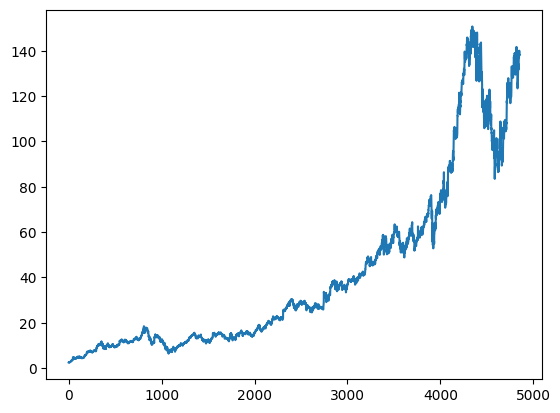

In [ ]:
comp_name = 'GOOG' # company for which stocks to be predicted
X, Y = generate_series(data[comp_name], 100)
his1 = data[comp_name].reset_index()['Close']
plt.plot(his1) # plotting the entire data we have(train, validation, test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = [MinMaxScaler(feature_range=(0, 1)) for _ in range(X.shape[2])]
X = [scaler[i].fit_transform(X[:,:,i]) for i in range(X.shape[2])]
Y = scaler[0].fit_transform(Y.reshape((-1,1)))
X = torch.tensor([[[*k] for k in zip(*sublists)] for sublists in zip(*X)])
X = torch.tensor(X, dtype = torch.float)
Y = torch.tensor(Y, dtype = torch.float)

In [ ]:
def split_data(X, Y, p1, p2): # 1-p1-p2 | p1 | p2, train | valid | test
    lookback1 = int(p2*len(X))
    lookback2 = int(p1*len(X))
    X_test = X[-1*lookback1:]
    Y_test = Y[-1*lookback1:]
    X_val = X[-1*(lookback1+lookback2):-1*lookback1]
    Y_val = Y[-1*(lookback1+lookback2):-1*lookback1]
    X_train = X[:-1*(lookback1+lookback2)]
    Y_train = Y[:-1*(lookback1+lookback2)]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X,Y, 0.1,0.1)

#converting data into tensor batches
from torch.utils.data import DataLoader, TensorDataset

vectorized_train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(vectorized_train_dataset, batch_size=128, shuffle=True)

vectorized_val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(vectorized_val_dataset, batch_size=128, shuffle=False)

## LSTM Model

In [ ]:
from torch import nn
from torch.nn import functional as F

class StockPredictor(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden, carry = torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(X_batch)
        return self.linear(self.dropout(output[:,-1, :]))

## Training models like LSTM's, GRU's

In [ ]:
def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10): # training the model using validation and train data
  set_seed(42)
  best_checkpoint = None
  val_prev_loss = 10000000.0
  avg_losses = []
  val_avg_losses = []

  for i in range(1, epochs+1):
    losses = []
    print("Current epoch: ", i)
    model.train()
    ## Training step
    for X, Y in train_loader:
        Y_preds = model(X.to(device))
        loss = loss_fn(Y_preds, Y.to(device))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_losses.append(torch.tensor(losses).mean().item())
    print("Training Loss:", torch.tensor(losses).mean().item())
    ## Validation step
  val_losses = []
  model.eval()
  with torch.no_grad():
      for X, Y in val_loader:
          Y_preds = model(X.to(device))
          loss = loss_fn(Y_preds, Y.to(device))
          val_losses.append(loss.item())
  val_avg_losses.append(torch.tensor(val_losses).mean().item())
  print("Validation Loss:",torch.tensor(val_losses).mean().item())
  ## Selecting best model
  # if torch.tensor(val_losses).mean().item() < val_prev_loss:
      # print("checkpointing current model")
  best_checkpoint = copy.deepcopy(model)
  val_prev_loss = torch.tensor(val_losses).mean().item()
  return best_checkpoint, val_prev_loss, model, avg_losses, val_avg_losses

In [ ]:
from torch.optim import Adam

l_epochs = [50,100]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

avg_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l, val_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    print("checkpointing current model")
    if((sum(val_l)/len(val_l)) < avg_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      avg_loss = (sum(val_l)/len(val_l))
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1
Training Loss: 0.007551036309450865
Current epoch:  2
Training Loss: 0.0009085838100872934
Current epoch:  3
Training Loss: 0.0006061693420633674
Current epoch:  4
Training Loss: 0.000457476795418188
Current epoch:  5
Training Loss: 0.0003658135246951133
Current epoch:  6
Training Loss: 0.00033823581179603934
Current epoch:  7
Training Loss: 0.00033538127900101244
Current epoch:  8
Training Loss: 0.0002972297661472112
Current epoch:  9
Training Loss: 0.00027534764376468956
Current epoch:  10
Training Loss: 0.00026113595231436193
Current epoch:  11
Training Loss: 0.0002543677401263267
Current epoch:  12
Training Loss: 0.0002530984638724476
Current epoch:  13
Training Loss: 0.00025753339286893606
Current epoch:  14
Training Loss: 0.0002714173460844904
Current epoch:  15
Training Loss: 0.00024656817549839616
Current epoch:  16
Training Loss: 0.00026671920204535127
Current epoch:  17
Training Loss: 0.00026513796183280647
Current epoch: 

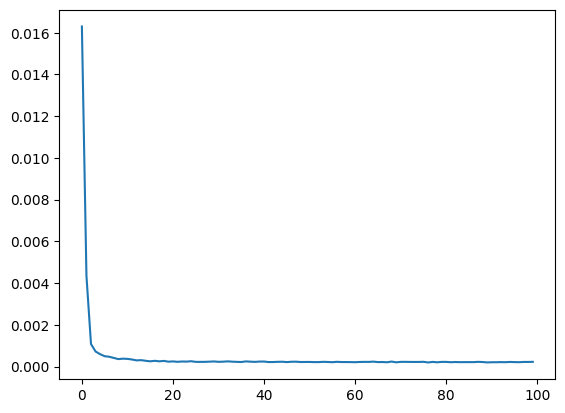

In [ ]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using LSTM

In [ ]:
model = best_checkpoint

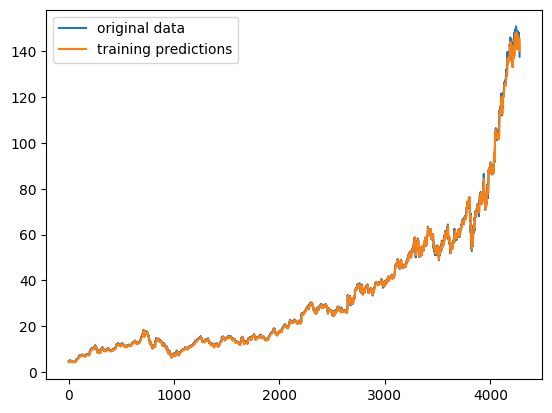

In [ ]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [ ]:
### Calculate RMSE performance metrics
Y_test = scaler[0].inverse_transform(Y_test)
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 3.034115063745782
MAE: 2.4031107627229136
MAE: 0.02084525531674927


##Plotting predicted data using LSTM

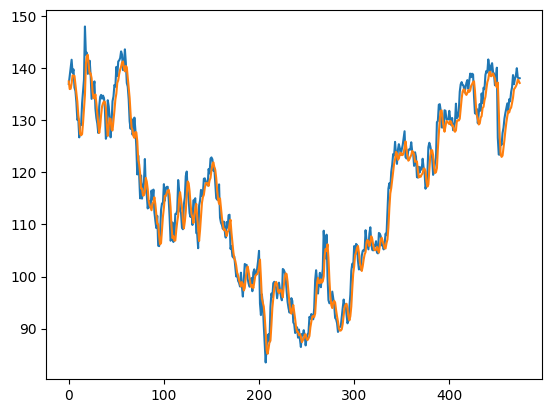

In [ ]:
plt.plot(Y_test.tolist())
plt.plot(closing_price)
plt.show()

## GRU Model

In [ ]:
class StockPredictor_v2(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_dim).requires_grad_().to(device)
        output, (hidden) = self.gru(X_batch.to(device), (hidden.detach()))
        return self.linear(self.dropout(output[:,-1, :]))

In [ ]:
from torch.optim import Adam

l_epochs = [50,100]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

avg_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor_v2(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l, val_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    if((sum(val_l)/len(val_l)) < avg_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      avg_loss = (sum(val_l)/len(val_l))
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1
Training Loss: 0.005216187797486782
Current epoch:  2
Training Loss: 0.0006260037189349532
Current epoch:  3
Training Loss: 0.0003740161773748696
Current epoch:  4
Training Loss: 0.00029019624344073236
Current epoch:  5
Training Loss: 0.00027825485449284315
Current epoch:  6
Training Loss: 0.00027184508508071303
Current epoch:  7
Training Loss: 0.0002638070145621896
Current epoch:  8
Training Loss: 0.00024091523664537817
Current epoch:  9
Training Loss: 0.0002464557474013418
Current epoch:  10
Training Loss: 0.0002730480919126421
Current epoch:  11
Training Loss: 0.0002573695674072951
Current epoch:  12
Training Loss: 0.0002678728778846562
Current epoch:  13
Training Loss: 0.0002558292471803725
Current epoch:  14
Training Loss: 0.0002389692672295496
Current epoch:  15
Training Loss: 0.00025405915221199393
Current epoch:  16
Training Loss: 0.0002687773376237601
Current epoch:  17
Training Loss: 0.0002576602855697274
Current epoch:  1

best checkpoint hyper parameters no of layers= 1


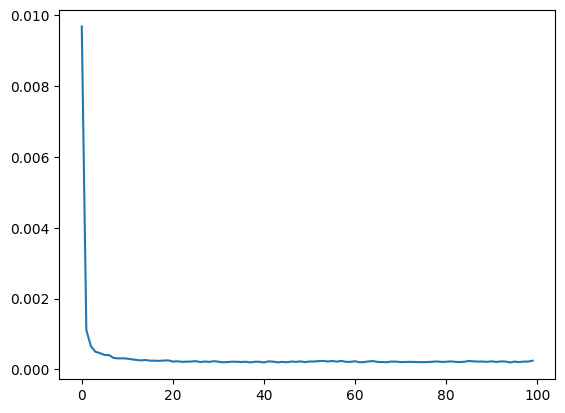

In [ ]:
print("best checkpoint hyper parameters no of layers=",best_checkpoint.num_layers)
plt.plot(avg_losses) #plot of training losses

##Predicting test data using GRU

In [ ]:
model = best_checkpoint

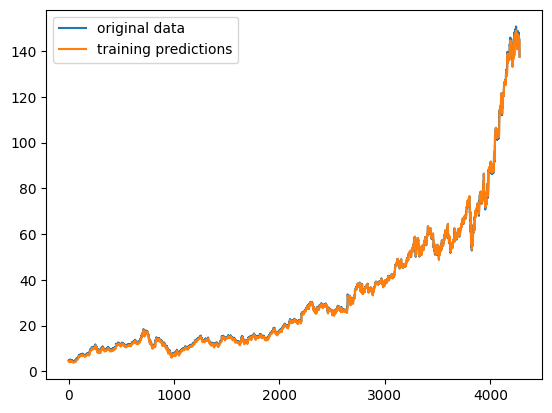

In [ ]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 2.56473915217812
MAE: 1.9697701023194876
MAE: 0.017277624931819186


##Plotting predicted data using GRU


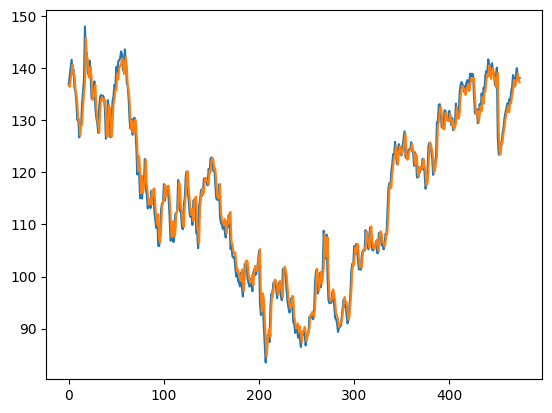

In [ ]:
plt.plot(Y_test.tolist(), label='original data')
plt.plot(closing_price, label='Test Predictions')
plt.show()